In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats

sc.settings.verbosity = 3

In [2]:
import sys
sys.path.insert(0,'..')
import compactmarker

# 1. Load and clean data

We download data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056

Tirosh I, Izar B, Prakadan SM, Wadsworth MH 2nd et al. Dissecting the multicellular ecosystem of metastatic melanoma by single-cell RNA-seq. Science 2016 Apr 8;352(6282):189-96.

## 1.1 Preprocessing

We first rename duplicate gene names.

In [3]:
data = pd.read_table("../../Melanoma/GSE72056_melanoma_single_cell_revised_v2.txt", header=0)
def dedup(x):
    d = {}
    r = []
    for i in x:
        if i in d:
            d[i] += 1
            r.append(i + '_' + str(d[i]))
            print(i, 'renamed to', r[-1])
        else:
            d[i] = 1
            r.append(i)
    return r

data['Cell'] = dedup(data['Cell'])

data = data.T

data.columns = data.loc["Cell"]
data.drop('Cell', inplace=True)
data

MARCH2 renamed to MARCH2_2
MARCH1 renamed to MARCH1_2


Cell                         tumor malignant(1=no,2=yes,0=unresolved)  \
Cy72_CD45_H02_S758_comb         72                                  1   
CY58_1_CD45_B02_S974_comb       58                                  1   
Cy71_CD45_D08_S524_comb         71                                  2   
Cy81_FNA_CD45_B01_S301_comb     81                                  2   
Cy80_II_CD45_B07_S883_comb      80                                  2   
...                            ...                                ...   
CY75_1_CD45_CD8_7__S223_comb    75                                  1   
CY75_1_CD45_CD8_1__S65_comb     75                                  1   
CY75_1_CD45_CD8_1__S93_comb     75                                  1   
CY75_1_CD45_CD8_1__S76_comb     75                                  1   
CY75_1_CD45_CD8_7__S274_comb    75                                  1   

Cell                         non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)  \
Cy72_CD45_H02_S758_comb                                                       2             
CY58_1_CD45_B02_S974_comb                                                     1             
Cy71_CD45_D08_S524_comb                                                       0             
Cy81_FNA_CD45_B01_S301_comb                                                   0             
Cy80_II_CD45_B07_S883_comb                                                    0             
...                                                                         ...             
CY75_1_CD45_CD8_7__S223_comb                                                  1             
CY75_1_CD45_CD8_1__S65_comb                                                   1             
CY75_1_CD45_CD8_1__S93_comb                                                   1             
CY75_1_CD45_CD8_1__S76_comb                                                   1             
CY75_1_CD45_CD8_7__S274_comb                                                  0             

Cell                         C9orf152   RPS11   ELMO2 CREB3L1 PNMA1     MMP2  \
Cy72_CD45_H02_S758_comb             0  9.2172       0       0     0        0   
CY58_1_CD45_B02_S974_comb           0  8.3745       0       0     0        0   
Cy71_CD45_D08_S524_comb             0   9.313  2.1263       0     0  0.73812   
Cy81_FNA_CD45_B01_S301_comb         0  7.8876       0       0     0        0   
Cy80_II_CD45_B07_S883_comb          0  8.3291       0       0     0        0   
...                               ...     ...     ...     ...   ...      ...   
CY75_1_CD45_CD8_7__S223_comb        0  5.4889       0       0     0        0   
CY75_1_CD45_CD8_1__S65_comb         0  4.9262  5.5296       0     0        0   
CY75_1_CD45_CD8_1__S93_comb         0  7.0958       0       0     0        0   
CY75_1_CD45_CD8_1__S76_comb         0   3.997       0       0     0        0   
CY75_1_CD45_CD8_7__S274_comb        0  3.9897       0       0     0        0   

Cell                          TMEM216  ...    GPLD1 SNORD115-39   RAB8A RXFP2  \
Cy72_CD45_H02_S758_comb             0  ...  0.62667           0       0     0   
CY58_1_CD45_B02_S974_comb           0  ...   1.0545           0       0     0   
Cy71_CD45_D08_S524_comb             0  ...  0.99639           0  2.7634     0   
Cy81_FNA_CD45_B01_S301_comb         0  ...  0.23143           0  4.1937     0   
Cy80_II_CD45_B07_S883_comb     3.7949  ...        0           0  2.5705     0   
...                               ...  ...      ...         ...     ...   ...   
CY75_1_CD45_CD8_7__S223_comb        0  ...   1.2962           0       0     0   
CY75_1_CD45_CD8_1__S65_comb         0  ...  0.99245           0       0     0   
CY75_1_CD45_CD8_1__S93_comb         0  ...  0.97516           0       0     0   
CY75_1_CD45_CD8_1__S76_comb         0  ...  0.49208           0       0     0   
CY75_1_CD45_CD8_7__S274_comb  0.29007  ...   1.0682           0       0     0   

Cell                           PCIF1 PIK3IP1  SNRPD2 SLC39A6    CTSC AQP

We then separate metadata from gene expression and remove ERCC spike-ins. 

In [4]:
obs = data[['tumor', 'malignant(1=no,2=yes,0=unresolved)', 'non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)']]
data.drop(['tumor', 'malignant(1=no,2=yes,0=unresolved)', 'non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)'], 
          axis=1, inplace=True)
print(*data.columns[data.columns.str.startswith('ERCC')], 'are dropped')
data = data.loc[:, data.columns.str.startswith('ERCC') == False]

obs

ERCC5 ERCC8 ERCC1 ERCC4 ERCC6L ERCC6L2 ERCC3 ERCC6 ERCC2 are dropped


Cell                         tumor malignant(1=no,2=yes,0=unresolved)  \
Cy72_CD45_H02_S758_comb         72                                  1   
CY58_1_CD45_B02_S974_comb       58                                  1   
Cy71_CD45_D08_S524_comb         71                                  2   
Cy81_FNA_CD45_B01_S301_comb     81                                  2   
Cy80_II_CD45_B07_S883_comb      80                                  2   
...                            ...                                ...   
CY75_1_CD45_CD8_7__S223_comb    75                                  1   
CY75_1_CD45_CD8_1__S65_comb     75                                  1   
CY75_1_CD45_CD8_1__S93_comb     75                                  1   
CY75_1_CD45_CD8_1__S76_comb     75                                  1   
CY75_1_CD45_CD8_7__S274_comb    75                                  1   

Cell                         non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)  
Cy72_CD45_H02_S758_comb                                                       2            
CY58_1_CD45_B02_S974_comb                                                     1            
Cy71_CD45_D08_S524_comb                                                       0            
Cy81_FNA_CD45_B01_S301_comb                                                   0            
Cy80_II_CD45_B07_S883_comb                                                    0            
...                                                                         ...            
CY75_1_CD45_CD8_7__S223_comb                                                  1            
CY75_1_CD45_CD8_1__S65_comb                                                   1            
CY75_1_CD45_CD8_1__S93_comb                                                   1            
CY75_1_CD45_CD8_1__S76_comb                                                   1            
CY75_1_CD45_CD8_7__S274_comb                                                  0            

[4645 rows x 3 columns]

In [5]:
pd.crosstab(obs['malignant(1=no,2=yes,0=unresolved)'], obs['non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)'])

non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)   0.0   1.0  2.0  \
malignant(1=no,2=yes,0=unresolved)                                              
0.0                                                             90    24    3   
1.0                                                            416  2040  512   
2.0                                                           1252     4    0   

non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)  3.0  4.0  5.0  \
malignant(1=no,2=yes,0=unresolved)                                            
0.0                                                             6    3    5   
1.0                                                           119   62   56   
2.0                                                             1    0    0   

non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)  6.0  
malignant(1=no,2=yes,0=unresolved)                                 
0.0                                                             1  
1.0                                                            51  
2.0                                                             0

In [6]:
# Suppress SettingWithCopyWarning
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Rename cell types for better appearance

malignant_dict = ['unresolved', 'normal', 'malignant']
celltype_dict = ['bordercase', 'T', 'B', 'Macro', 'Endo', 'CAF', 'NK']
obs['tumor'] = obs['tumor'].apply(lambda x: 'Mel' + str(int(x)))
obs['malignant'] = obs['malignant(1=no,2=yes,0=unresolved)'].astype(int).apply(malignant_dict.__getitem__)
obs['celltype'] = obs['non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)'].astype(int).apply(celltype_dict.__getitem__)
obs.loc[obs['malignant'] == 'malignant', 'celltype'] = 'malignant'

## 1.2 Create AnnData for scanpy

In [8]:
adata = sc.AnnData(data)
for i in obs.columns:
    adata.obs[i] = obs[i]

In [9]:
adata

AnnData object with n_obs × n_vars = 4645 × 23677
    obs: 'tumor', 'malignant(1=no,2=yes,0=unresolved)', 'non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)', 'malignant', 'celltype'

# 2 Typical SCANPY analysis

## 2.1 QC

### 2.1.1 Highly Expressed Genes

normalizing counts per cell
    finished (0:00:00)


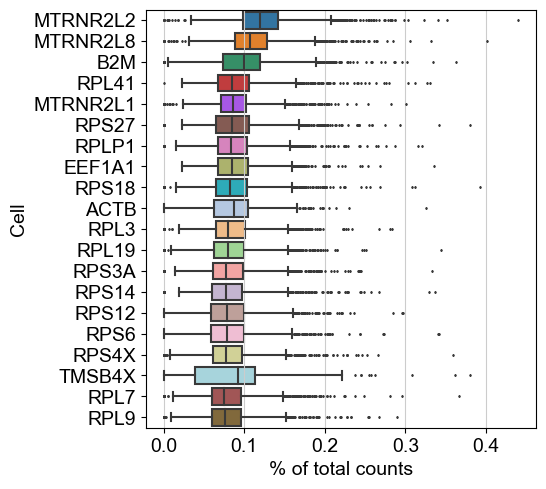

In [22]:
sc.settings.set_figure_params(dpi=50, facecolor='white')
sc.pl.highest_expr_genes(adata, n_top=20)

No mitochonrial genes available, which is okay.

C:\Users\SLiang3\Miniconda3\envs\scanpy37\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\SLiang3\Miniconda3\envs\scanpy37\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\SLiang3\Miniconda3\envs\scanpy37\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\SLiang3\Miniconda3\envs\scanpy37\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


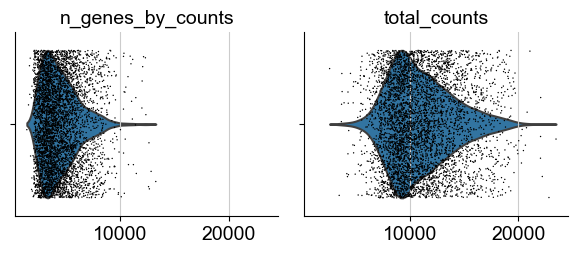

In [25]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

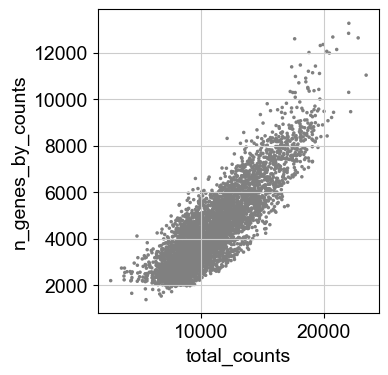

In [26]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [27]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

C:\Users\SLiang3\Miniconda3\envs\scanpy37\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 1397 genes that are detected in less than 3 cells


In [28]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [29]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


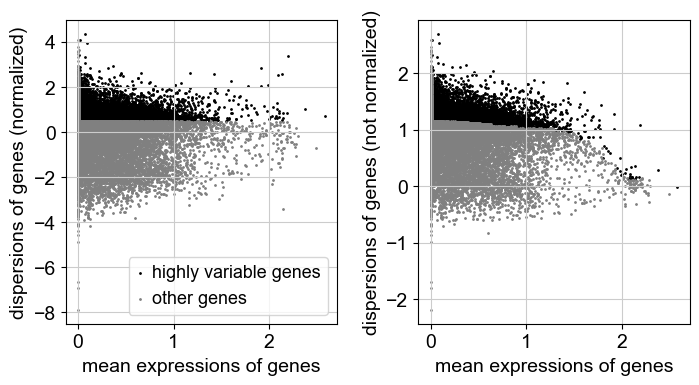

In [30]:
sc.pl.highly_variable_genes(adata)

In [31]:
adata.raw = adata

In [32]:
adata = adata[:, adata.var.highly_variable]

In [33]:
sc.pp.scale(adata, max_value=10)

C:\Users\SLiang3\Miniconda3\envs\scanpy37\lib\site-packages\scanpy\preprocessing\_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [34]:
adata

AnnData object with n_obs × n_vars = 4645 × 6219
    obs: 'tumor', 'malignant(1=no,2=yes,0=unresolved)', 'non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)', 'malignant', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [35]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


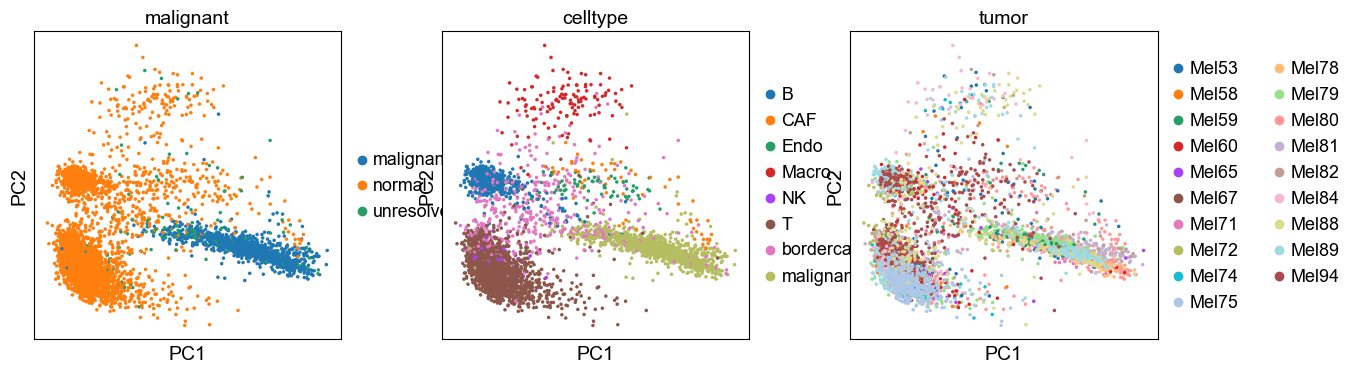

In [36]:
sc.pl.pca(adata, color=['malignant', 'celltype', 'tumor'])

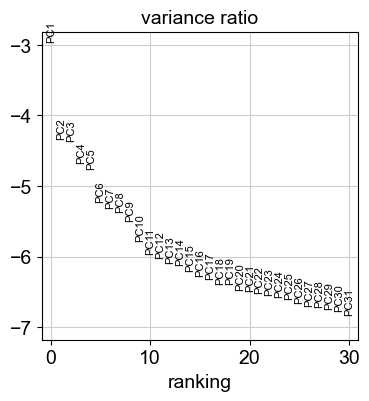

In [38]:
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


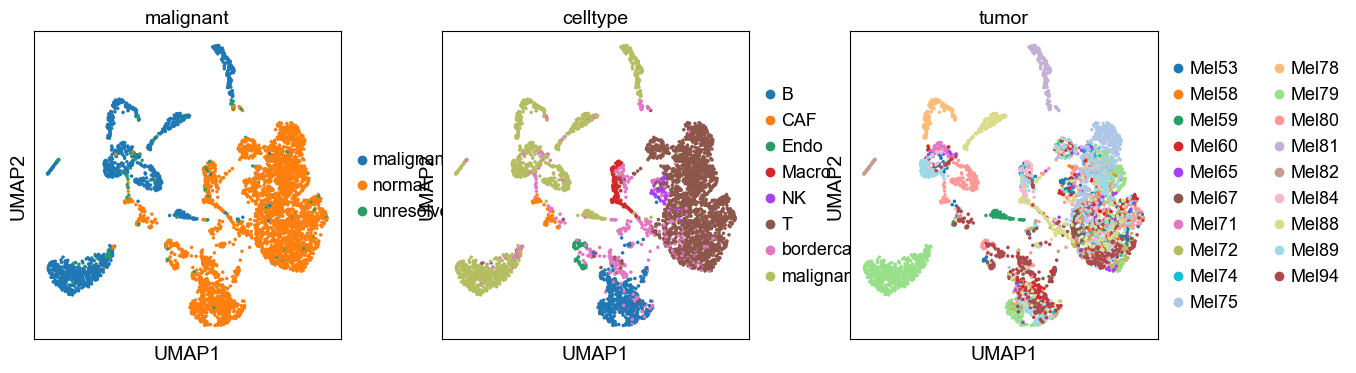

In [39]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['malignant', 'celltype', 'tumor'])

# 3. SCMER Feature Selection

Each step contains 20 inner iterations. It can be seen that the algorithm converges in 40~60 iternations.

As a rule of thumb, the loss should end up with 3.0~4.0. 
0.0 is perfect but it needs many features. 
A loss greater than 4.0 usually mean that the manifold is not well retained.

In [40]:
model = compactmarker.UmapL1(lasso=3.87e-4, ridge=0., n_pcs=40, perplexity=100., use_beta_in_Q=True, n_threads=6, pca_seed=2020)
model.fit(adata.X)

Calculating distance matrix and scaling factors...
Computing pairwise distances...
Using 6 threads...
Mean value of sigma: 1.206104
Done. Elapsed time: 23.37 seconds. Total: 23.37 seconds.
Creating model without batches...
Optimizing using OWLQN (because lasso is nonzero)...
0 loss: 6.253872871398926 Nonzero: 80 Elapsed time: 84.96 seconds. Total: 108.33 seconds.
1 loss: 3.090698003768921 Nonzero: 76 Elapsed time: 81.01 seconds. Total: 189.34 seconds.
2 loss: 3.0756547451019287 Nonzero: 75 Elapsed time: 94.89 seconds. Total: 284.24 seconds.
3 loss: 3.0753679275512695 Nonzero: 75 Elapsed time: 100.09 seconds. Total: 384.33 seconds.
4 loss: 3.0753376483917236 Nonzero: 75 Elapsed time: 77.42 seconds. Total: 461.75 seconds.
final loss: 2.9645748138427734 Nonzero: 75 Elapsed time: 1.41 seconds. Total: 463.16 seconds.


Selected markers:

In [41]:
print(*adata.var_names[model.get_mask()])

RPS11 CXCL13 B2M GNLY SERPINA3 CD55 TXNIP DEDD RPS4Y1 RGS1 PTPRC PDCD1 HAVCR2 A2M TYR COL1A2 VIM SRGN ELK2AP NME2 GPR183 CDH5 PAEP KIT CCR7 TCL1A ANXA1 C1orf56 NKG7 MFAP4 GZMH MTRNR2L2 GZMA CD52 RGS10 CXCR4 MIR4461 COL1A1 TYMS MCM5 OAS2 PTPRCAP PMEL SPOCK2 PRAME AURKB MIA SELPLG APOD UXS1 IFITM1 MAGEC2 TYROBP IRF8 CD69 CD8A TNFAIP3 HLA-DQA1 TIGIT CD27 MS4A1 LSP1 TCF7 C10orf54 SYTL3 TOB1 CCL4 TOX PRDM1 CTLA4 GZMB HAPLN3 HLA-DQB1 HLA-DPA1 LTB


# 4. Validation

## 4.1 PCA and UMAP validation

The PCA and UMAP largely resemble the ones obtained from all genes.

computing PCA
    on highly variable genes
    with n_comps=50


C:\Users\SLiang3\Miniconda3\envs\scanpy37\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:00)


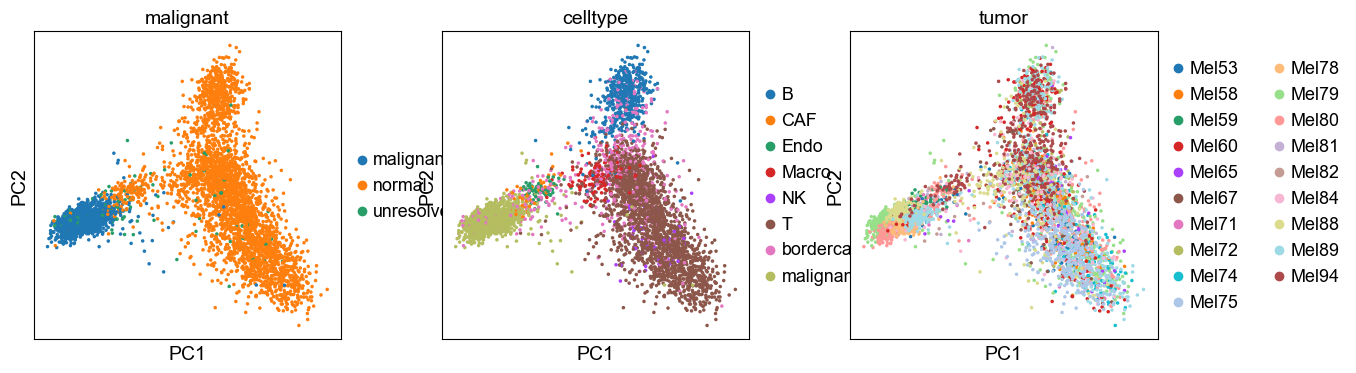

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


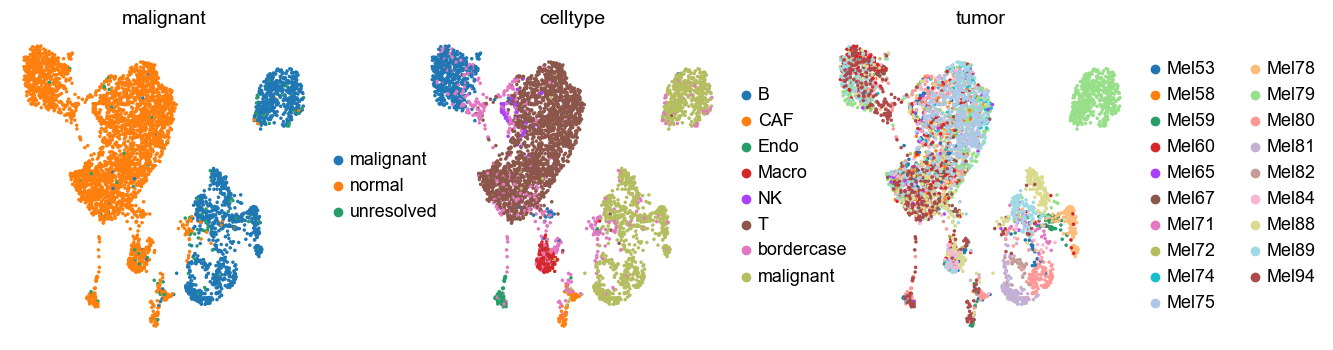

In [42]:
new_adata = model.transform(adata)
sc.tl.pca(new_adata, svd_solver='arpack')
sc.pl.pca(new_adata, color=['malignant', 'celltype', 'tumor'])
sc.pp.neighbors(new_adata, n_pcs=10, use_rep="X_pca")
sc.tl.umap(new_adata)
sc.pl.umap(new_adata, color=['malignant', 'celltype', 'tumor'], frameon=False)

## 4.2 Gene sets analysis

### 4.2.1 Gene sets from the original publication

In [49]:
import pickle as pkl
with open("../../Melanoma/markers.pkl", 'rb') as file:
    markers = pkl.load(file)

selected_markers = adata.var_names[model.get_mask()].tolist()
all_markers = adata.var_names.tolist()
    
for i in markers:
    print(i, len(set(markers[i]).intersection(set(selected_markers))), '/', 
          len(set(markers[i]).intersection(set(all_markers))), "(", len(markers[i]), "):", end=" ")
    print(*set(markers[i]).intersection(set(selected_markers)))

axl 2 / 52 ( 100 ): HAPLN3 CD52
mitf 3 / 28 ( 100 ): PMEL TYR TOB1
cell-cycle 3 / 54 ( 93 ): AURKB TYMS MCM5
melanoma 5 / 19 ( 47 ): PRAME PMEL TYR MIA SERPINA3
b 2 / 27 ( 31 ): IRF8 MS4A1
t 7 / 38 ( 38 ): TCF7 TOX PRDM1 CD8A NKG7 TIGIT SPOCK2
macro 1 / 73 ( 92 ): TYROBP
endo 2 / 45 ( 95 ): HAPLN3 CDH5
caf 3 / 46 ( 88 ): COL1A1 COL1A2 MFAP4
exhaustion-consistent 3 / 17 ( 28 ): CD27 CXCL13 TIGIT
exhaustion_variable 7 / 159 ( 272 ): PDCD1 TOX HLA-DPA1 SRGN IRF8 HAVCR2 CTLA4


### 4.2.2 Genes not in the gene sets above

In [50]:
temp = set(selected_markers.copy())
for i in markers:
    temp -= set(markers[i])
    
print(*temp)

IFITM1 RPS11 GNLY C1orf56 DEDD A2M VIM GZMB SYTL3 TXNIP CCR7 CD55 PTPRC RGS1 TNFAIP3 B2M RPS4Y1 PAEP CXCR4 LTB LSP1 SELPLG UXS1 MTRNR2L2 KIT GZMA ELK2AP MAGEC2 MIR4461 HLA-DQA1 TCL1A ANXA1 HLA-DQB1 PTPRCAP APOD C10orf54 GPR183 RGS10 OAS2 CD69 GZMH NME2 CCL4


### 4.2.3 Genes in EMT pathway

In [51]:
emt_markers = compactmarker.Comparison.read_gmt(
    "../../Melanoma/HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION.gmt")['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION']

compactmarker.Comparison.compare(y_true=emt_markers, y_pred=selected_markers)

'4/200 recalled in the gene set by 75 predicted genes, overlapping genes are COL1A1, COL1A2, TNFAIP3, VIM.'

## 4.3 Scatter Plot of the Selected Features

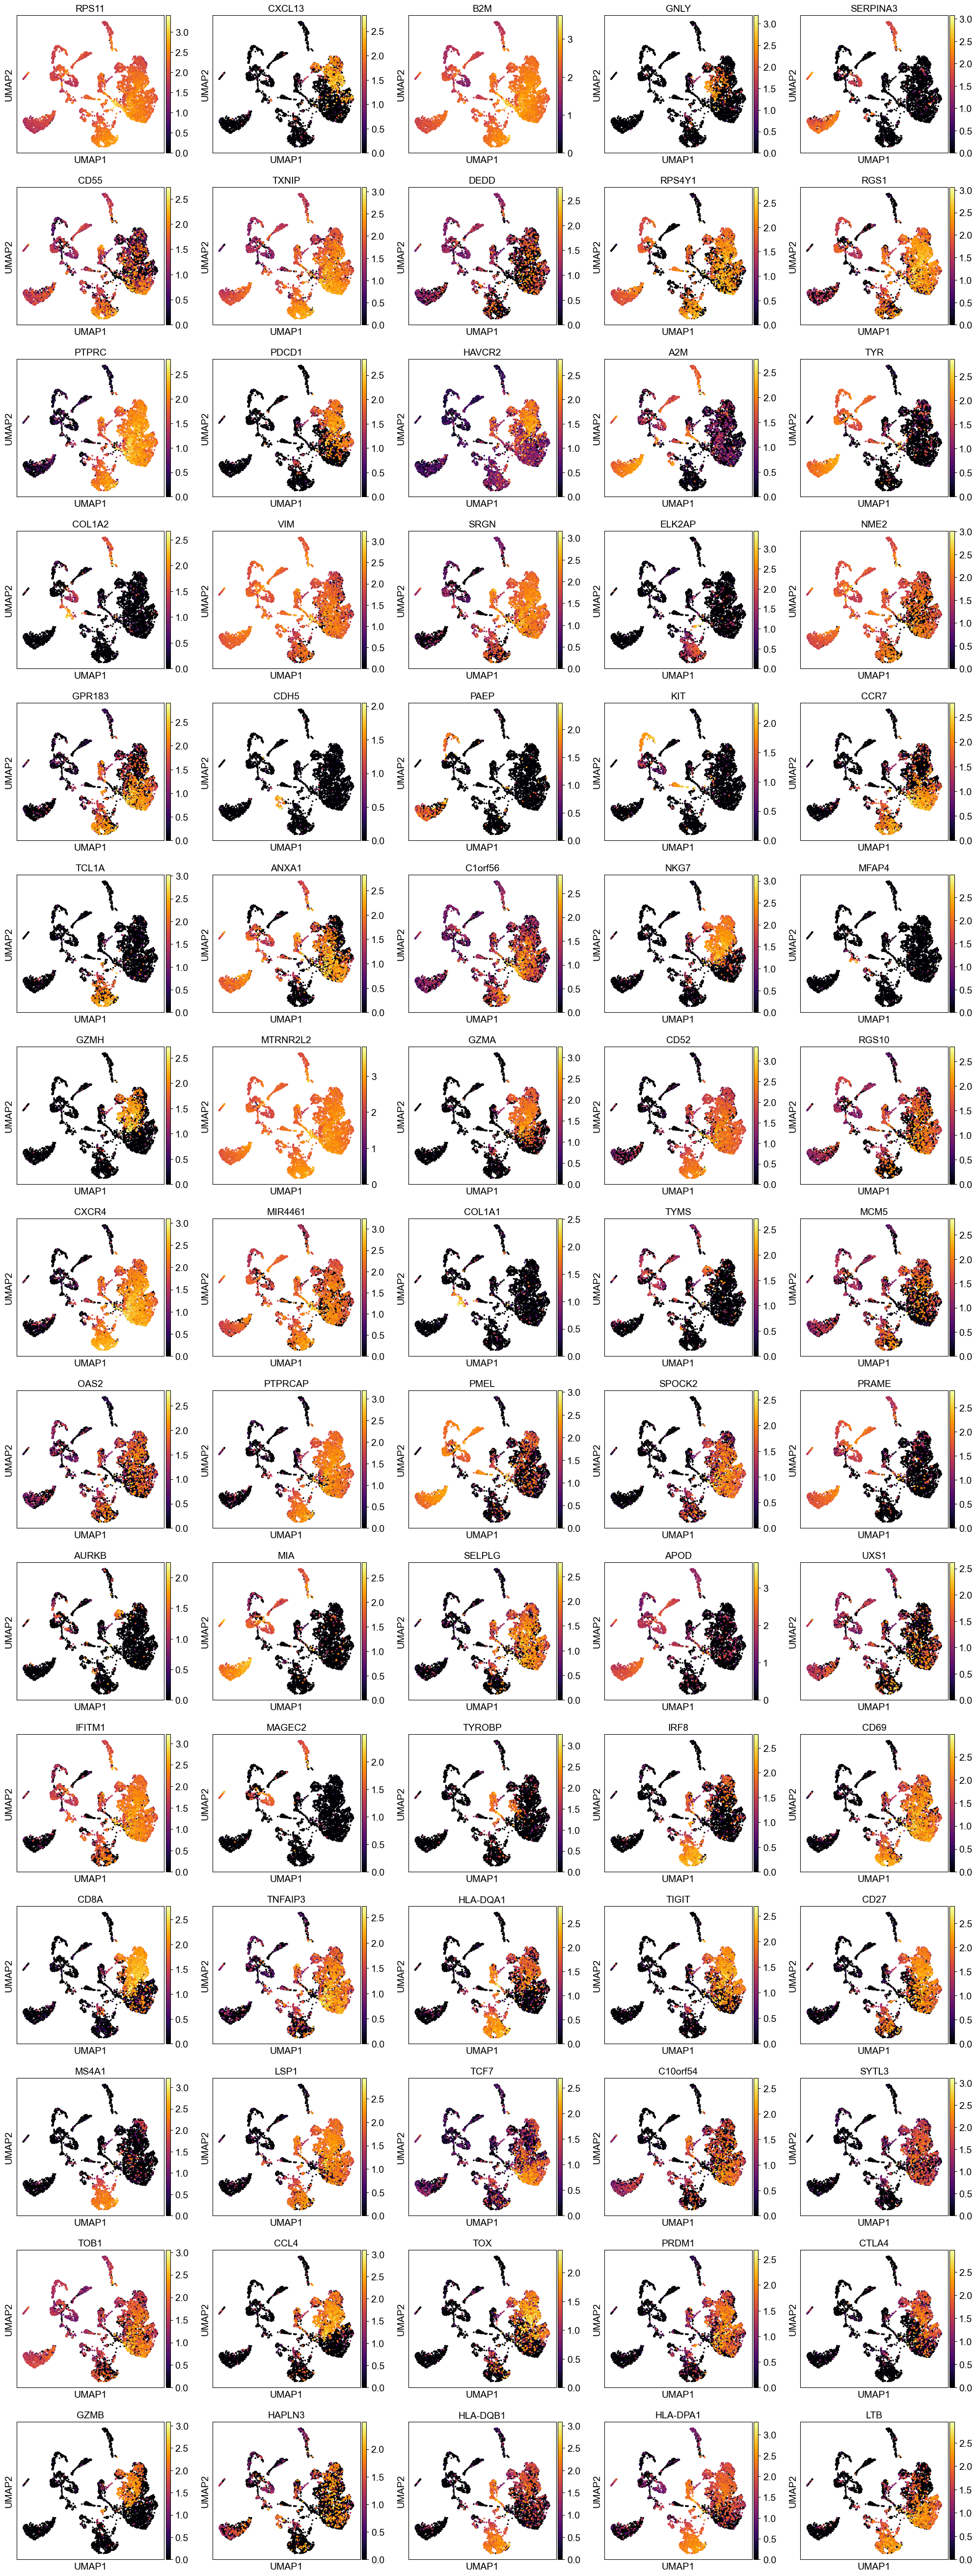

In [56]:
sc.settings.set_figure_params(dpi=50, facecolor='white')
sc.pl.umap(adata, color=selected_markers, ncols=5, legend_loc="on data", legend_fontsize=8., color_map="inferno")